In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random
import csv

/home/ziyi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Network Parameters
num_input = 6
timesteps = 100 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [3]:
def read_sensor(filename):
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        dataset = [row[17:23] for row in reader]
        #data_x
        return np.array(dataset)
    
def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    #L-1 R-0
    strike_times.append([0.0, 0.5])
    for i in range(len(all_foot)):
        if(all_foot[i]=='L'):
            strike_times.append([float(all_time[i]), 1])
        else:
            strike_times.append([float(all_time[i]), 0])
    strike_times[-1][1] = 0.5
    strike_times.append([length/25.0, 0.5])

    window_y = []
    strike_index=0
    for i in range(length):
        if(i/25.0 >= strike_times[strike_index+1][0]):
            strike_index += 1
        window_y.append([strike_times[strike_index][1]])

    p_info = re.compile(r'<StartTime>(.*?)</StartTime>\n\t<EndTime>(.*?)</EndTime>\n\t<NSteps>(.*?)</NSteps>\n\t<Direction>(.*?)</Direction>')
    all_info = p_info.findall(cts)#start_time, end_time, step_num, direction=turn

    for i in range(len(all_info)):
        if(all_info[i][3][:4]=='Turn'):
#             print(all_info[i])
            start_time = int(float(all_info[i][0])*25)
            end_time = int(float(all_info[i][1])*25)
#             print('start and end time : ', all_info[i][0], all_info[i][1])
            for t in range(start_time-1, end_time):
                window_y[t] = [0.5]

    p_feature = re.compile(r'<Feature>\n\t\t\t<StartTime>(.*?)</StartTime>\n\t\t\t<EndTime>(.*?)</EndTime>')
    all_feature = p_feature.findall(cts)#start_time, end_time, step_num, direction=turn
    
#     print(filename, length)
    for i in range(len(all_feature)):
        start_time = int(float(all_feature[i][0])*25)
        end_time = int(float(all_feature[i][1])*25)
#         print(start_time-1, end_time)
        if(end_time<=length):
            for t in range(start_time-1, end_time):
                window_y[t] = [0.5]
            
#     print(len(window_y))  
    return window_y

def add_data(path, person, phone_location, assistant):
    data_x = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(path)+'_ID'+str(person)+'_'+phone_location+'_'+assistant+'.csv')
    data_y = read_xml('weallwalk/xml/T'+str(path)+'_ID'+str(person)+'_'+assistant+'.xml', len(data_x))
    
    split_x, split_x_part = [], []
    split_y, split_y_part = [], []
    for i in range(len(data_y)):
        if(data_y[i][0]!=0.5):
            split_y_part.append(data_y[i])
            split_x_part.append(data_x[i])
        else:
            if(len(split_y_part)>0):
                split_y.append(split_y_part)
                split_x.append(split_x_part)
                split_y_part = []
                split_x_part = []
    
    data_x_seq, data_y_seq = [], []
    for i in range(len(split_x)):
        data_x_part, data_y_part = [], []
        for j in range(len(split_x[i])-timesteps):
            x = split_x[i][j:j+timesteps]
            y = split_y[i][j:j+timesteps]
            data_x_part.append(x)
            data_y_part.append(y)
        if(len(data_x_part)>0):
            data_x_seq.append(data_x_part)
            data_y_seq.append(data_y_part)
    
    return data_x_seq, data_y_seq

In [4]:
step_data_list = []
#[4, 6, '2R', 'WC']
for i in range(1,7):
    step_data_list.append([i, 1, '1L', 'WC'])
    step_data_list.append([i, 1, '2R', 'WC'])
    step_data_list.append([i, 2, '1L', 'WC'])
    step_data_list.append([i, 2, '2R', 'WC'])
    
    step_data_list.append([i, 3, '1L', 'WC'])
    step_data_list.append([i, 3, '2R', 'WC'])
    step_data_list.append([i, 5, '1L', 'WC'])
    step_data_list.append([i, 5, '2R', 'WC'])
    
    
    step_data_list.append([i, 6, '1L', 'WC'])
    step_data_list.append([i, 6, '2R', 'WC'])
    step_data_list.append([i, 7, '1L', 'WC'])
    step_data_list.append([i, 7, '2R', 'WC'])
#     step_data_list.append([i, 8, '1L', 'WC'])
#     step_data_list.append([i, 8, '2R', 'WC'])   

step_data_list.append([7, 9, '1L', 'WC'])
step_data_list.append([8, 9, '1L', 'WC'])
step_data_list.append([9, 10, '1L', 'WC'])
step_data_list.append([10, 10, '1L', 'WC'])                          

step_data_list.append([7, 9, '2R', 'WC'])
step_data_list.append([8, 9, '2R', 'WC'])
step_data_list.append([9, 10, '2R', 'WC'])
step_data_list.append([10, 10, '2R', 'WC'])

step_data_list.remove([4, 6, '2R', 'WC'])
print(step_data_list)

[[1, 1, '1L', 'WC'], [1, 1, '2R', 'WC'], [1, 2, '1L', 'WC'], [1, 2, '2R', 'WC'], [1, 3, '1L', 'WC'], [1, 3, '2R', 'WC'], [1, 5, '1L', 'WC'], [1, 5, '2R', 'WC'], [1, 6, '1L', 'WC'], [1, 6, '2R', 'WC'], [1, 7, '1L', 'WC'], [1, 7, '2R', 'WC'], [2, 1, '1L', 'WC'], [2, 1, '2R', 'WC'], [2, 2, '1L', 'WC'], [2, 2, '2R', 'WC'], [2, 3, '1L', 'WC'], [2, 3, '2R', 'WC'], [2, 5, '1L', 'WC'], [2, 5, '2R', 'WC'], [2, 6, '1L', 'WC'], [2, 6, '2R', 'WC'], [2, 7, '1L', 'WC'], [2, 7, '2R', 'WC'], [3, 1, '1L', 'WC'], [3, 1, '2R', 'WC'], [3, 2, '1L', 'WC'], [3, 2, '2R', 'WC'], [3, 3, '1L', 'WC'], [3, 3, '2R', 'WC'], [3, 5, '1L', 'WC'], [3, 5, '2R', 'WC'], [3, 6, '1L', 'WC'], [3, 6, '2R', 'WC'], [3, 7, '1L', 'WC'], [3, 7, '2R', 'WC'], [4, 1, '1L', 'WC'], [4, 1, '2R', 'WC'], [4, 2, '1L', 'WC'], [4, 2, '2R', 'WC'], [4, 3, '1L', 'WC'], [4, 3, '2R', 'WC'], [4, 5, '1L', 'WC'], [4, 5, '2R', 'WC'], [4, 6, '1L', 'WC'], [4, 7, '1L', 'WC'], [4, 7, '2R', 'WC'], [5, 1, '1L', 'WC'], [5, 1, '2R', 'WC'], [5, 2, '1L', 'WC'],

In [5]:
data_x, data_y = [], []
for i in step_data_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    for dx in data_x_segement:
        data_x.extend(dx)
    for dy in data_y_segement:
        data_y.extend(dy)
    
print(len(data_x))
print(len(data_y))

191794
191794


In [6]:
order = list(range(0,len(data_x),1))
random.shuffle(order)

train_x = [data_x[i] for i in order]
train_y = [data_y[i] for i in order]

print(len(train_x))

191794


In [7]:
step_test_list = []
for i in range(1,7):
    step_test_list.append([i, 8, '1L', 'WC'])
    step_test_list.append([i, 8, '2R', 'WC'])  
      
print(step_test_list)

[[1, 8, '1L', 'WC'], [1, 8, '2R', 'WC'], [2, 8, '1L', 'WC'], [2, 8, '2R', 'WC'], [3, 8, '1L', 'WC'], [3, 8, '2R', 'WC'], [4, 8, '1L', 'WC'], [4, 8, '2R', 'WC'], [5, 8, '1L', 'WC'], [5, 8, '2R', 'WC'], [6, 8, '1L', 'WC'], [6, 8, '2R', 'WC']]


In [8]:
test_x, test_y=[], []
for i in step_test_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    test_x.extend(data_x_segement)
    test_y.extend(data_y_segement)
#     test_x.append(data_x_segement)
#     test_y.append(data_y_segement)
    
print(len(test_x))
print(len(test_y))

print([len(i) for i in test_y])

60
60
[63, 199, 890, 43, 63, 199, 890, 43, 50, 1320, 110, 26, 50, 1320, 110, 26, 1687, 324, 1687, 324, 361, 1597, 250, 1216, 330, 869, 109, 812, 361, 1597, 250, 1216, 330, 869, 109, 812, 91, 342, 791, 274, 154, 161, 302, 467, 332, 211, 91, 342, 791, 274, 154, 161, 302, 467, 332, 211, 778, 1355, 778, 1355]


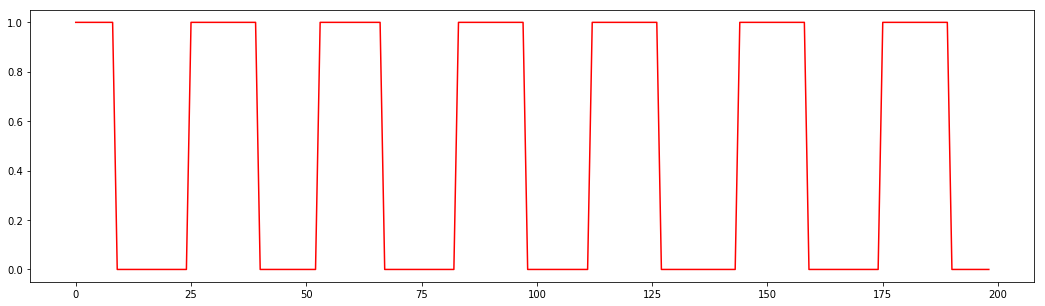

In [9]:
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in test_y[1]], 'r')
plt.show()

In [10]:
NUM_LAYERS=2

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden)#, forget_bias=1.0)
    cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=0.5)
    return cell

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, timesteps, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

#         return tf.matmul(outputs[-2], weights['out']) + biases['out']
        ret = []
#         print(outputs.shape)
        for i in range(0, timesteps):
            ret.append(tf.matmul(outputs[i], weights['out']) + biases['out'])
            
        return ret

#         return np.array(ret)
    
    logits = RNN(X, weights, biases)
    logits = tf.transpose(logits, [1,0,2])
#     print(len(logits))
    print(logits.shape)
    print(logits[0].shape)
    mean_train = tf.reduce_mean(X)
    
    
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    
    saver = tf.train.Saver()

(?, 100, 1)
(100, 1)


In [11]:
batch_size = 256
batch_start = 0;
train_length = len(train_x)
print(train_length)

train_x_extend = [i for i in train_x]
train_y_extend = [i for i in train_y]

print(len(train_x_extend))

191794
191794


In [12]:
if(len(train_x_extend)==len(train_x)):
    train_x_extend.extend(train_x[0:batch_size])
    train_y_extend.extend(train_y[0:batch_size])
print(len(train_x_extend))

192050


In [15]:
def cal_accuarcy(y, _y):
#     print(len(y))
#     print(len(y[0]))
#     print(len(y[0][0]))
#     print(y[0][0])
    count = 0
    total = 0
    for i in range(len(y[0])):
        total += 1
        if(y[0][i][0] == round(_y[0][i][0])):
            count += 1
    for i in range(1, len(y)):
        total += 1
        if(y[i][-1][0] == round(_y[i][-1][0])):
            count += 1;
    return(count*1.0/total)
#     print("train accuarcy : ", count/len(y))

In [49]:
training_steps = 801

config = tf.ConfigProto(allow_soft_placement=True)
# config.gpu_options.allocator_type = 'BFC'
# config.gpu_options.per_process_gpu_memory_fraction = 0.40
with tf.Session(graph=graph, config=config) as session:
#     saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
    saver.restore(session, "lstm_check/my-model-gpu-error-metric-dropout2-wc-time40.ckpt-2000")
#     tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(training_steps):      
        feed_dict = {X: train_x[batch_start:batch_start+batch_size], Y: train_y[batch_start:batch_start+batch_size]}
        _, l, predictions, m = session.run([optimizer, loss, logits, mean_train], feed_dict = feed_dict)
        if (step % 100 == 0):
            train_accuarcy = cal_accuarcy(train_y[batch_start:batch_start+batch_size], predictions)
            print('Loss at step %d: %f, train accuarcy : %f' % (step, l, train_accuarcy))
            #train accuarcy
        if (step % 1000 == 0):
            saver.save(session, 'lstm_check/my-model-gpu-error-metric-dropout2-wc-time100.ckpt', global_step=step+4000)
        batch_start += batch_size
        if(batch_start>=train_length):
            batch_start -=train_length
#     train_loss, train_logits = session.run([loss,logits], feed_dict={X: train_x, Y: train_y})
#     test_loss, test_logits = session.run([loss,logits], feed_dict={X: test_x, Y: test_y})
    test_loss, test_logits = [], []
    for i in range(len(test_x)):
#         saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
        test_loss_part, test_logits_part = session.run([loss,logits], feed_dict={X: test_x[i], Y: test_y[i]})
        test_loss.append(test_loss_part)
        test_logits.append(test_logits_part)

INFO:tensorflow:Restoring parameters from lstm_check/my-model-gpu-error-metric-dropout2-wc-time40.ckpt-2000
Initialized
Loss at step 0: 0.131428, train accuarcy : 0.861972
Loss at step 100: 0.100069, train accuarcy : 0.898592
Loss at step 200: 0.097710, train accuarcy : 0.878873
Loss at step 300: 0.092012, train accuarcy : 0.904225
Loss at step 400: 0.095113, train accuarcy : 0.918310
Loss at step 500: 0.092687, train accuarcy : 0.921127
Loss at step 600: 0.083470, train accuarcy : 0.915493
Loss at step 700: 0.084551, train accuarcy : 0.901408
Loss at step 800: 0.084721, train accuarcy : 0.901408


In [50]:
print(len(test_logits))
print(len(test_logits[0]))
print(len(test_logits[0][0]))  

test_y_seq_list, test_logits_bin_list = [], []

for t in test_logits:  
    t_all = [i for i in t[0]]
    t_all.extend([i[-1] for i in t[1:]])
#     print(len(t_all)-len(t))
    
    test_logits_part = [[round(i[0])] for i in t_all]
    for i in range(1, len(test_logits_part)-1):
        if(test_logits_part[i-1][0]!=test_logits_part[i][0] and test_logits_part[i-1][0]==test_logits_part[i+1][0]):
            test_logits_part[i][0]=test_logits_part[i-1][0]    
    test_logits_bin_list.append(test_logits_part)
    
for t in test_y:  
    t_all = [i for i in t[0]]
    t_all.extend([i[-1] for i in t[1:]])
    test_y_seq_list.append(t_all)

# print(test_y_seq_list)
    
count = 0
total = 0
for i in range(0, len(test_y_seq_list)):
    total += len(test_y_seq_list[i])
    for j in range(0, len(test_y_seq_list[i])):
        if(test_y_seq_list[i][j][0] == test_logits_bin_list[i][j][0]):
            count += 1

print(count)
print(total)
print("test accuarcy : ", count*1.0/total)

60
63
100
30598
36968
test accuarcy :  0.8276888119454664


In [51]:
step_time_actual, step_time_predict= [], []
step_time_actual_gap = []

#test_y_seq_list, test_logits_bin_list
for i in range(0, len(test_y_seq_list)):
    step_time_actual_part, step_time_predict_part= [], []
    for j in range(1, len(test_y_seq_list[i])):
        if(abs(test_y_seq_list[i][j][0]-test_y_seq_list[i][j-1][0])>0.5):
            step_time_actual_part.append(j)
    #     if(abs(test_logits[i][0]-test_logits[i-1][0])>0.5):
        if(abs(test_logits_bin_list[i][j][0]-test_logits_bin_list[i][j-1][0])>0.5):
            step_time_predict_part.append(j)
    step_time_actual.append(step_time_actual_part)
    step_time_predict.append(step_time_predict_part)
    
    step_time_actual_gap_part = []
    step_time_actual_gap_part.append(0)
#     step_time_actual_gap_part.append(step_time_actual_part[0]/2.0)
    for i in range(1, len(step_time_actual_part)):
        step_time_actual_gap_part.append((step_time_actual_part[i-1]+step_time_actual_part[i])/2.0)
    step_time_actual_gap_part.append(step_time_actual_part[-1]*2)
    step_time_actual_gap.append(step_time_actual_gap_part)

print('Step number for each segement')
print([len(i) for i in step_time_actual])   
print([len(i) for i in step_time_predict])

# print('======')
# iii = 13
# print(step_time_actual[iii])
# print(step_time_actual_gap[iii])
# print(step_time_predict[iii])

Step number for each segement
[11, 20, 70, 9, 11, 20, 70, 9, 10, 95, 14, 7, 10, 95, 14, 7, 112, 28, 112, 28, 31, 104, 19, 93, 19, 68, 13, 64, 31, 104, 19, 93, 19, 68, 13, 64, 12, 33, 55, 26, 16, 19, 27, 40, 29, 22, 12, 33, 55, 26, 16, 19, 27, 40, 29, 22, 57, 96, 57, 96]
[11, 26, 71, 14, 11, 20, 71, 9, 11, 103, 15, 10, 11, 98, 15, 8, 129, 31, 119, 30, 38, 117, 21, 92, 27, 68, 15, 65, 34, 111, 23, 94, 24, 68, 13, 64, 15, 33, 65, 28, 16, 18, 31, 40, 30, 21, 13, 35, 63, 28, 18, 20, 28, 40, 30, 23, 56, 102, 58, 98]


In [52]:
print(step_time_actual[0])
print(step_time_predict[0])

[13, 28, 43, 58, 73, 88, 100, 117, 131, 147, 160]
[3, 25, 44, 55, 73, 85, 100, 112, 130, 142, 161]


In [53]:
total_step_count = sum([len(i) for i in step_time_actual])
metric1_undercount = 0
metric2_undercount = 0
metric3_undercount = 0
metric1_overcount = 0
metric2_overcount = 0
metric3_overcount = 0

metric2_overcount_list = []
metric3_overcount_list = []

print(len(test_x))

for i in range(len(test_x)):
    step_count = len(step_time_actual[i])
    undercount = 0
    overcount = 0

    for j in range(1, step_count):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][j-1] and t<step_time_actual[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += len(gap_count)-1
        if(len(gap_count)<1):
            undercount += 1
    gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][-1]]
    if(len(gap_count)>1):
        overcount += len(gap_count)-1
    if(len(gap_count)<1):
        undercount += 1
    
    metric1_undercount += undercount
    metric1_overcount += overcount
    
    undercount = 0
    overcount = 0
    for j in range(1, len(step_time_actual_gap[i])):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual_gap[i][j-1] and t<step_time_actual_gap[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += (len(gap_count)-1)
        if(len(gap_count)<1):
            undercount += 1    
    
    metric2_undercount += undercount
    metric2_overcount += overcount  
    metric2_overcount_list.append(overcount)
    
#     print(undercount, overcount)
#     print('undercount : ', undercount*1.0/step_count)
#     print('overcount : ', overcount*1.0/step_count)
    diff = len(step_time_predict[i])-len(step_time_actual[i])
#     if(diff==0):
#         print("segement correct!")

    if(diff<0):
#         print('segement undercount : ', 1-len(step_time_predict[i])*1.0/len(step_time_actual[i]))
        metric3_undercount -= diff
        metric3_overcount_list.append(0)
#     if(diff>=0):
    else:
#         print('segement overcount : ', 1-len(step_time_actual[i])*1.0/len(step_time_predict[i]))
        metric3_overcount += diff
        metric3_overcount_list.append(diff)

print(len(metric2_overcount_list))
print(sum(metric2_overcount_list))
print(metric2_overcount_list)
print(len(metric3_overcount_list))
print(sum(metric3_overcount_list))
print(metric3_overcount_list)
        
print('error : ')
print("total undercount metric 1:\t", metric1_undercount*1.0/total_step_count)
print("total overcount metric 1:\t", metric1_overcount*1.0/total_step_count)
print("total undercount metric 2:\t", metric2_undercount*1.0/total_step_count)
print("total overcount metric 2:\t", metric2_overcount*1.0/total_step_count)
print("total undercount metric 3:\t", metric3_undercount*1.0/total_step_count)
print("total overcount metric 3:\t", metric3_overcount*1.0/total_step_count)

60
60
178
[0, 6, 1, 5, 0, 0, 1, 0, 1, 8, 1, 3, 1, 4, 1, 1, 18, 4, 7, 2, 8, 18, 2, 0, 10, 1, 2, 1, 3, 8, 4, 1, 5, 0, 0, 0, 3, 0, 10, 2, 0, 0, 4, 0, 1, 0, 1, 2, 9, 2, 2, 1, 1, 0, 1, 1, 0, 7, 2, 2]
60
162
[0, 6, 1, 5, 0, 0, 1, 0, 1, 8, 1, 3, 1, 3, 1, 1, 17, 3, 7, 2, 7, 13, 2, 0, 8, 0, 2, 1, 3, 7, 4, 1, 5, 0, 0, 0, 3, 0, 10, 2, 0, 0, 4, 0, 1, 0, 1, 2, 8, 2, 2, 1, 1, 0, 1, 1, 0, 6, 1, 2]
error : 
total undercount metric 1:	 0.21780147662018048
total overcount metric 1:	 0.2559474979491386
total undercount metric 2:	 0.008203445447087777
total overcount metric 2:	 0.07301066447908121
total undercount metric 3:	 0.0016406890894175555
total overcount metric 3:	 0.06644790812141099
